# Incidence de la varicelle

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

## Importation du jeu de données

Les données de l'incidence de la varicelle sont disponibles sur le [site du réseau Sentinelles](https://www.sentiweb.fr/france/fr/?page=accueil), dans la section "Surveillance continue" puis "Bases de données". 

In [2]:
data_url = "https://www.sentiweb.fr/datasets/all/inc-7-PAY.csv"

In [7]:
raw_data = pd.read_csv(data_url, skiprows=1)
raw_data.head()

week  indicator   inc  inc_low  inc_up  inc100  inc100_low  inc100_up  \
0  202434          7  2831      415    5247       4           0          8   
1  202433          7  1955      511    3399       3           1          5   
2  202432          7  4399     1944    6854       7           3         11   
3  202431          7  4500     2213    6787       7           4         10   
4  202430          7  7004     4278    9730      11           7         15   

  geo_insee geo_name  
0        FR   France  
1        FR   France  
2        FR   France  
3        FR   France  
4        FR   France

Vérifions maintenant qu'il n'y a pas de données manquantes ainsi que le type de la colonne ```"inc"```, qui contient les données qui nous intéressent.

In [10]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

In [11]:
raw_data["inc"].dtype

dtype('int64')

Il n'y a pas de données manquantes dans le jeu de données, et l'incidence a bien été traitée comme une série de nombres entiers. Nous pouvons donc travailler directement sur les données brutes.

In [14]:
data = raw_data.copy()

## Préparation du jeu de données

Désormais, il nous faut convertir le format de semaine donné dans le jeu de données en un format compréhensible par Pandas.

In [15]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Définissons la nouvelle série ```"period"``` comme l'index du jeu de données et trions-le en conséquence.

In [16]:
sorted_data = data.set_index('period').sort_index()

In [26]:
sorted_data.head()

week  indicator    inc  inc_low  inc_up  inc100  \
period                                                                     
1990-12-03/1990-12-09  199049          7   1143        0    2610       2   
1990-12-10/1990-12-16  199050          7  11079     6660   15498      20   
1990-12-17/1990-12-23  199051          7  19080    13807   24353      34   
1990-12-24/1990-12-30  199052          7  19375    13295   25455      34   
1990-12-31/1991-01-06  199101          7  15565    10271   20859      27   

                       inc100_low  inc100_up geo_insee geo_name  
period                                                           
1990-12-03/1990-12-09           0          5        FR   France  
1990-12-10/1990-12-16          12         28        FR   France  
1990-12-17/1990-12-23          25         43        FR   France  
1990-12-24/1990-12-30          23         45        FR   France  
1990-12-31/1991-01-06          18         36        FR   France

Vérifions la cohérence du jeu de données, en s'assurant que les dates de fin d'une période correspondent bien aux dates de début de la période suivante.

In [19]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Aucune ligne n'est ressortie comme étant anormale ; nous pouvons donc poursuivre notre analyse. Portons donc un premier regard sur les données.

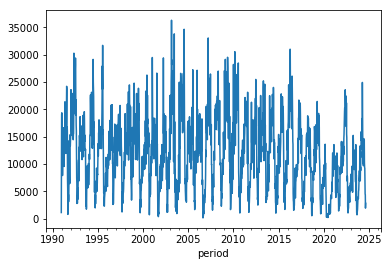

In [21]:
sorted_data['inc'].plot()

Le même regard, sur une période plus récente :

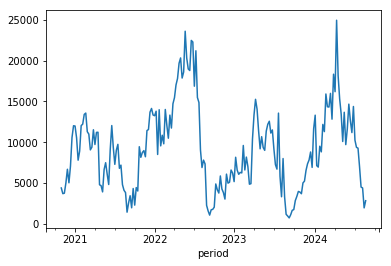

In [23]:
sorted_data['inc'][-200:].plot()

## Etude de l'incidence annuelle

Nous observons que l'incidence semble périodique, avec un creux chaque année autour de septembre. Vérifions cela en traçant sur le même graphique que précédemment des lignes horizontales là où nous aimerions définir le début de notre période.

In [27]:
first_september_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

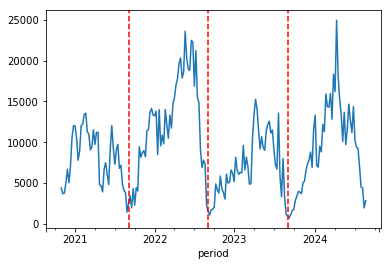

In [42]:
ax = sorted_data['inc'][-200:].plot()
for w in first_september_week:
    if w >= sorted_data.index[-200]:
        ax.axvline(w, color="red", linestyle="--")

Ce découpage a l'air tout à fait satisfaisant visuellement. Nous pouvons donc le conserver et procéder à une analyse annuelle où nos périodes commencent le premier septembre de chaque année.

In [43]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_september_week[:-1],
                        first_september_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

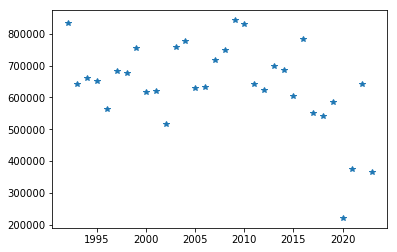

In [45]:
yearly_incidence.plot(style='*')

On constate d'emblée une incidence remarquablement faible en 2020, année du Covid et des confinements qui en ont découlé. En triant les données, on peut ainsi observer les années ayant vu le plus de cas se produire.

In [46]:
yearly_incidence.sort_values()

2020    221186
2023    366227
2021    376290
2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2022    641397
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64

Enfin, un histogramme montre la distribution des incidences anuelles.

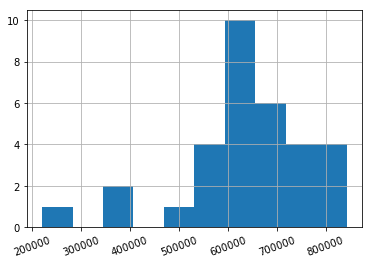

In [49]:
yearly_incidence.hist(xrot=20)